<a href="https://colab.research.google.com/github/TuringCollegeSubmissions/vpaula-DS.3.4/blob/master/341.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Home Credit Default Risk. Median Kaggle private leaderboard score: 0.78593

For this project, I chose to participate in the [Home Credit Default Risk Kaggle competition](https://www.kaggle.com/c/home-credit-default-risk/overview). The objective of this competition is to predict how capable each applicant is of repaying a loan.

## Imports

In [1]:
# Automatic formatting with black
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
# Data wrangling
import pandas as pd
import numpy as np

# Data preprocessing
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# Visualisations
from matplotlib import pyplot as plt
import seaborn as sns

# Evaluation
from sklearn.model_selection import cross_val_score

# File system manangement
import os

# Options
RANDOM_STATE = 42
from sklearn import set_config

set_config(display="diagram")

<IPython.core.display.Javascript object>

In [3]:
app_train = pd.read_csv("data/application_train.csv")

<IPython.core.display.Javascript object>

In [4]:
app_test = pd.read_csv("data/application_test.csv")

<IPython.core.display.Javascript object>

## Helper functions

In [5]:
def save_submission_csv(predictions: pd.Series) -> None:
    """
    Save predictions to a csv for Kaggle submission

    Args:
        predictions (pd.Series): Predictions to be saved
    """

    sub = pd.read_csv("sample_submission.csv")
    sub["TARGET"] = predictions[:, 1]

    sub.to_csv(r"submission.csv", index=False)

<IPython.core.display.Javascript object>

In [6]:
def cross_val_roc_auc(pipeline: Pipeline, X: pd.DataFrame, y: pd.Series) -> np.float64:
    """
    Returns cross validated area under the receiver operating characteristic curve to estimate Kaggle score

    Args:
        pipeline (sklearn.pipeline.Pipeline): Pipeline to test
        X (pd.DataFrame): Feature values
        y (pd.Series): Target values

    Returns:
        np.float64: Cross validated area under the receiver operating characteristic curve
    """

    score = cross_val_score(pipeline, X, y, cv=5, scoring="roc_auc")

    return np.sqrt(score).mean()

<IPython.core.display.Javascript object>

##  Basic EDA

In [7]:
print(os.listdir("data/"))

['application_test.csv', 'application_train.csv', 'bureau.csv', 'bureau_balance.csv', 'credit_card_balance.csv', 'HomeCredit_columns_description.csv', 'installments_payments.csv', 'POS_CASH_balance.csv', 'previous_application.csv']


<IPython.core.display.Javascript object>

There are a total of 9 files: 1 main file for training (with target) 1 main file for testing (without the target), 1 example submission file, and 6 other files containing additional information about each loan.

### Initial look at the main data

In [8]:
print("Training data shape: ", app_train.shape)

app_train.head(3)

Training data shape:  (307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


<IPython.core.display.Javascript object>

The training data has 307511 samples (each one a separate loan) and 122 features (variables) including the TARGET (the label we want to predict).

In [9]:
print("Testing data shape: ", app_test.shape)

app_test.head(3)

Testing data shape:  (48744, 121)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0


<IPython.core.display.Javascript object>

The testing data set is smaller and lacks the "TARGET" column

### Initial look at the target

In [10]:
app_train["TARGET"].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

<IPython.core.display.Javascript object>

The target data is made up of zeros and ones, which indicate that this will be a binary classification problem. The target data is made up of zeros and ones, which indicate that this will be a binary classification problem. From the initial documentation, we know that the target stands for whether there were problems repaying the loan: "0" if the loan was repaid successfully and "1" if there were problems

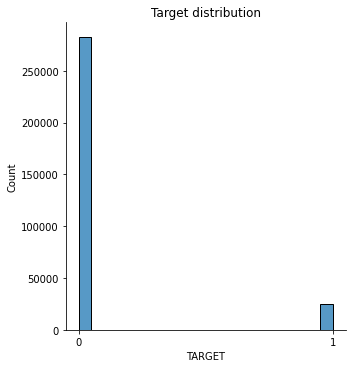

<IPython.core.display.Javascript object>

In [11]:
sns.displot(app_train["TARGET"])
plt.xticks([0, 1])
plt.title("Target distribution")
plt.show()

We can see that the classes are unbalanced and there are over ten times the examples of '0' than there are of '1', which could impact our prediction accuracy. We will need to keep this in mind when perfoming feature engineering and scoring the models

### Missing values

In [12]:
# Checking if there are missing values and if futher analysis is needed
app_train.isna().any().any()

True

<IPython.core.display.Javascript object>

Since there are missing values, a more in-depth analysis will be needed

In [453]:
# Function to calculate missing values by column, taken from Kaggle user Will Koehrsen EDA notebook


def missing_values_table(df):
    # Total missing values
    mis_val = df.isnull().sum()

    # Percentage of missing values
    mis_val_percent = 100 * df.isnull().sum() / len(df)

    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)

    # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(
        columns={0: "Missing Values", 1: "% of Total Values"}
    )

    # Sort the table by percentage of missing descending
    mis_val_table_ren_columns = (
        mis_val_table_ren_columns[mis_val_table_ren_columns.iloc[:, 1] != 0]
        .sort_values("% of Total Values", ascending=False)
        .round(1)
    )

    # Print some summary information
    print(
        "Your selected dataframe has " + str(df.shape[1]) + " columns.\n"
        "There are "
        + str(mis_val_table_ren_columns.shape[0])
        + " columns that have missing values."
    )

    # Return the dataframe with missing information
    return mis_val_table_ren_columns

<IPython.core.display.Javascript object>

In [454]:
missing_values = missing_values_table(app_train)
missing_values.head(20)

Your selected dataframe has 122 columns.
There are 67 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_AVG,213514,69.4
FONDKAPREMONT_MODE,210295,68.4
LIVINGAPARTMENTS_MODE,210199,68.4
LIVINGAPARTMENTS_MEDI,210199,68.4
LIVINGAPARTMENTS_AVG,210199,68.4


<IPython.core.display.Javascript object>

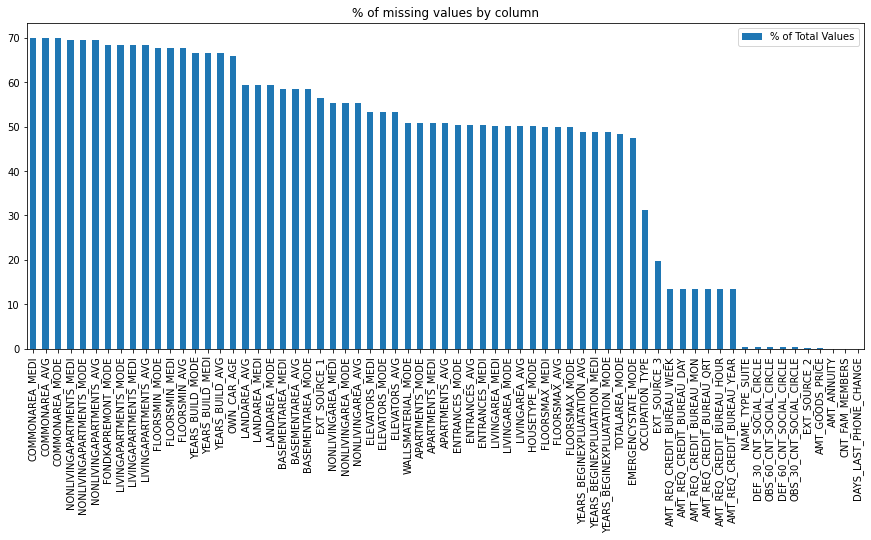

<IPython.core.display.Javascript object>

In [15]:
# Visual representation
missing_values[missing_values["Missing Values"] > 0.0].drop(
    "Missing Values", axis=1
).plot(kind="bar", figsize=(15, 6), title="% of missing values by column")

plt.show()

Over half of the features in the training dataset have missing values, which will become a problem when we try to build models, as models can not handle missing values. I will later try entirely dropping these columns or try imputing the missing values

### Missing values by class

I also want to make sure that the % of missing values is not significantly different between the classes

In [489]:
# Calculating missing values by class and adding a new column "Class"
missing_values_0 = missing_values_table(app_train[app_train["TARGET"] == 0])
missing_values_1 = missing_values_table(app_train[app_train["TARGET"] == 1])
missing_values_0["Class"] = 0
missing_values_1["Class"] = 1

missing_values = missing_values_0.append(missing_values_1)

missing_values = missing_values[missing_values["Missing Values"] > 0.0]
missing_values.head()

Your selected dataframe has 122 columns.
There are 67 columns that have missing values.
Your selected dataframe has 122 columns.
There are 64 columns that have missing values.


,Missing Values,% of Total Values,Class
COMMONAREA_MEDI,196442,69.5,0
COMMONAREA_AVG,196442,69.5,0
COMMONAREA_MODE,196442,69.5,0
NONLIVINGAPARTMENTS_MEDI,195187,69.0,0
NONLIVINGAPARTMENTS_MODE,195187,69.0,0


<IPython.core.display.Javascript object>

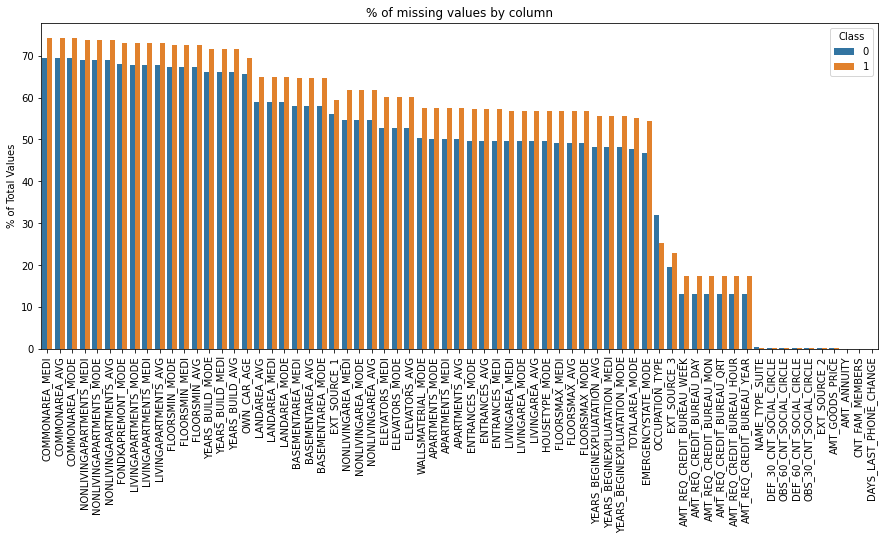

<IPython.core.display.Javascript object>

In [490]:
# Visual representation
plt.figure(figsize=(15, 6))

sns.barplot(
    x=missing_values.index,
    y=missing_values["% of Total Values"],
    data=missing_values,
    hue="Class",
)

plt.title("% of missing values by column")
plt.xticks(rotation=90)
plt.legend(loc="upper right", title="Class")
plt.show()

As we can see, there does not seem to be a lot of significant outliers and the percentage of missing values seem to be the same, although slightly higher for most of the features when it comes to the "1" class. There does seem to be only one outlying feature - "OCCUPATION_TYPE". We will see whether this feature will be important later on

### Feature data types

In [16]:
app_train.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

<IPython.core.display.Javascript object>

The features are mostly made up of numerical features, but do have some categorical features. These will need to be encoded or dropped before training a model

### Separate categorical and numerical columns


In [309]:
X = app_train.drop("TARGET", axis=1)

# Select categorical columns
categorical_cols = X.select_dtypes("object").columns

# Select numerical columns
numerical_cols = X.select_dtypes(exclude="object").columns

<IPython.core.display.Javascript object>

### Correlations

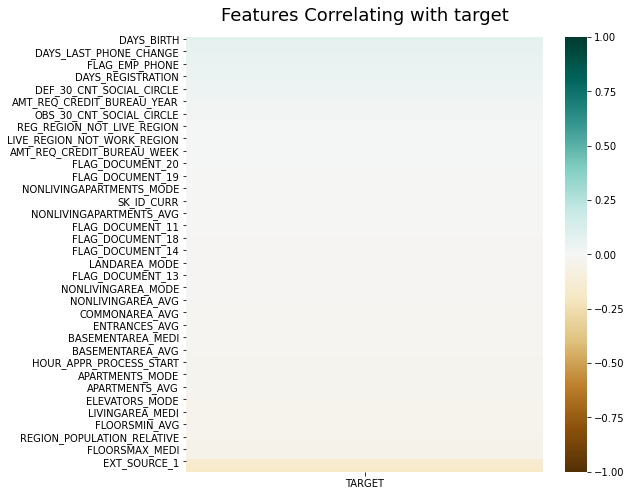

<IPython.core.display.Javascript object>

In [313]:
# Plot feature correlations with target

plt.figure(figsize=(8, 8))
heatmap = sns.heatmap(
    app_train.corr()[["TARGET"]].sort_values(by="TARGET", ascending=False)[1:],
    vmin=-1,
    vmax=1,
    cmap="BrBG",
)

heatmap.set_title("Features Correlating with target", fontdict={"fontsize": 18}, pad=16)
plt.show()

There does not seem to be any features with suspiciously high (or low) correlations with the target, which could indicate data contamination

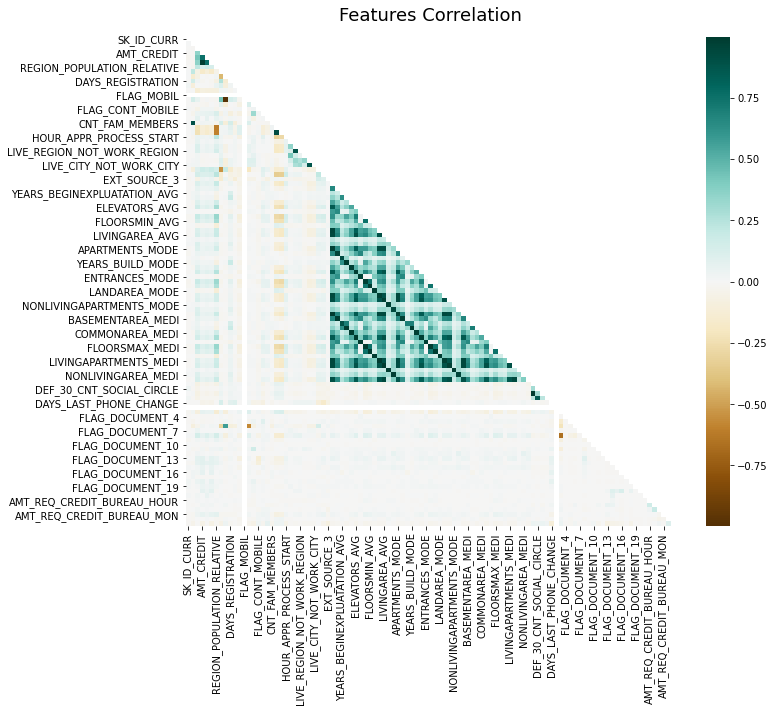

<IPython.core.display.Javascript object>

In [19]:
corr_data = app_train[numerical_cols].dropna().corr()

# Set up a custom shape mask
mask = np.triu(np.ones_like(corr_data, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(
    corr_data,
    mask=mask,
    cmap="BrBG",
    center=0,
    square=True,
)

plt.title("Features Correlation", fontdict={"fontsize": 18}, pad=16)

plt.show()

We can see from the plot that there seem to be very high (and low) correlations between the features, which could indicate that there are redundant features, which do not add any new information. Also, from the names of these features, seems like the dataset includes both the median and average values for some features

In [20]:
# Checking for correlations in all of the data
corrs = (
    app_train[numerical_cols]
    .corr()
    .abs()
    .unstack()
    .sort_values(kind="quicksort", ascending=False)
    .reset_index()
)

corrs = (
    corrs[corrs["level_0"] != corrs["level_1"]][::2]
    .reset_index(drop=True)
    .dropna()
    .rename(columns={0: "absolute_correlation"})
)

<IPython.core.display.Javascript object>

In [314]:
corrs.head(5)

,level_0,level_1,absolute_correlation
0,DAYS_EMPLOYED,FLAG_EMP_PHONE,0.999755
1,YEARS_BUILD_AVG,YEARS_BUILD_MEDI,0.998495
2,OBS_60_CNT_SOCIAL_CIRCLE,OBS_30_CNT_SOCIAL_CIRCLE,0.998490
3,FLOORSMIN_AVG,FLOORSMIN_MEDI,0.997241
4,FLOORSMAX_AVG,FLOORSMAX_MEDI,0.997034


<IPython.core.display.Javascript object>

The table confirms that there are features with a very high correlation (>0.99), but no duplicate features (with a correlation of 1). I have a suspicion that most of these features will be redundant, but will need to confirm this with feature importance

In [317]:
corrs[corrs["absolute_correlation"] >= 0.95].shape[0]

46

<IPython.core.display.Javascript object>

To be precise, there are 46 features with very high correlations (>=95%)

## Preprocessing

In [23]:
# Preprocessing for numerical data
numerical_transformer = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        ("imputer", SimpleImputer()),
    ]
)

# Preprocessing for categorical data
categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]
)

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_transformer, numerical_cols),
        ("cat", categorical_transformer, categorical_cols),
    ]
)

<IPython.core.display.Javascript object>

To avoid data leakage, I chose to use pipelines to do all of the preprocessing

## Baseline model. Achieved Kaggle score: 0.73394

Since the evaluation criteria require the model to be as simple and fast as possible, I will first try to achieve the required score with Logistic Regression

In [24]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000)

<IPython.core.display.Javascript object>

In [25]:
# Bundle preprocessing and modeling code in a pipeline
my_pipeline = Pipeline(steps=[("preprocessor", preprocessor), ("model", model)])

<IPython.core.display.Javascript object>

In [26]:
y = app_train["TARGET"]

<IPython.core.display.Javascript object>

In [27]:
# Evaluate the model
score = cross_val_roc_auc(my_pipeline, X, y)

print("Cross-validated mean AUCROC:", score)

Cross-validated mean AUCROC: 0.8639006359168784


<IPython.core.display.Javascript object>

In [28]:
%%time
my_pipeline.fit(X, y)

Wall time: 1min 47s


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler()),
                                                                  ('imputer',
                                                                   SimpleImputer())]),
                                                  Index(['SK_ID_CURR', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
       'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE',
       'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION',
       ...
       'FLAG_DOCUMENT_18', 'FLAG_...
                                                  Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
       'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE',
       'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE'],
      dtype='object'))])),
                ('model', LogisticRegression(max_iter=1000, random_state=42))])

<IPython.core.display.Javascript object>

In [29]:
%%time
preds = my_pipeline.predict_proba(app_test)

Wall time: 490 ms


<IPython.core.display.Javascript object>

In [30]:
save_submission_csv(preds)

<IPython.core.display.Javascript object>

## Baseline model classification report

Since the baseline model accuracy is low, let us explore it with a classification report and see where the model failed

In [31]:
from sklearn.model_selection import cross_val_predict

# Cross-validated predictions
y_pred = cross_val_predict(my_pipeline, X, y, cv=5)

<IPython.core.display.Javascript object>

In [32]:
from sklearn.metrics import classification_report

print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96    282686
           1       0.47      0.01      0.02     24825

    accuracy                           0.92    307511
   macro avg       0.70      0.51      0.49    307511
weighted avg       0.88      0.92      0.88    307511



<IPython.core.display.Javascript object>

As we can see from the classification report, the model is very accurate at guessing "0", but seems a lot less accurate at guessing "1". We can confirm this by exploring the predicted values

In [33]:
# Fastest way to check how many "1" there are is to just sum the array
np.sum(y_pred)

632

<IPython.core.display.Javascript object>

So the model predicts "1" $\frac{632}{24825}$ or 2.5% of the times, although it should predict "1" $\frac{24825}{307511}$ times. This could be influenced by the imbalanced dataset

In [432]:
# Calculating prediction (inference) time per sample
print(f"{0.490 / X.shape[0]} seconds per sample")

1.5934389338917956e-06 seconds per sample


<IPython.core.display.Javascript object>

## Baseline model. Undersampling majority class. Achieved Kaggle score: 0.73419

Since we have a lot of data, I chose to try the RandomUndersampler from the imbalanced learn package

In [365]:
from imblearn.under_sampling import RandomUnderSampler

# Declaring the random undersampler with a random state
rus = RandomUnderSampler(random_state=RANDOM_STATE)

# Resampling the data
X_resampled, y_resampled = rus.fit_resample(X, y)

<IPython.core.display.Javascript object>

In [35]:
y_resampled.value_counts()

0    24825
1    24825
Name: TARGET, dtype: int64

<IPython.core.display.Javascript object>

As we can see, it takes random samples of the majority class (in this case "0") and balances out the dataset to include the same amount of both classes. Let us try this new <i>balanced</i> dataset with the same baseline model

In [36]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000)

<IPython.core.display.Javascript object>

In [37]:
# Bundle preprocessing and modeling code in a pipeline
my_pipeline = Pipeline(steps=[("preprocessor", preprocessor), ("model", model)])

<IPython.core.display.Javascript object>

In [38]:
# Evaluate the model
score = cross_val_roc_auc(my_pipeline, X_resampled, y_resampled)

print("Cross-validated mean AUCROC:", score)

Cross-validated mean AUCROC: 0.8187122115113205


<IPython.core.display.Javascript object>

In [39]:
%%time
my_pipeline.fit(X_resampled, y_resampled)

Wall time: 12.8 s


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler()),
                                                                  ('imputer',
                                                                   SimpleImputer())]),
                                                  Index(['SK_ID_CURR', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
       'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE',
       'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION',
       ...
       'FLAG_DOCUMENT_18', 'FLAG_...
                                                  Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
       'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE',
       'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE'],
      dtype='object'))])),
                ('model', LogisticRegression(max_iter=1000, random_state=42))])

<IPython.core.display.Javascript object>

In [40]:
%%time
preds = my_pipeline.predict_proba(app_test)

Wall time: 381 ms


<IPython.core.display.Javascript object>

In [41]:
save_submission_csv(preds)

<IPython.core.display.Javascript object>

Although the Kaggle score did not change much, which is most likely explained by the scoring they use (ROC AUC is more robust to outliers), we need to look at the classification report to see where the model made mistakes. 

One advantage of undersampling was the reduction in time needed for training (<b>over 10x</b>) and slightly faster inference (prediction) times

## Undersampled baseline model classification report

In [42]:
# Cross-validated predictions
y_pred = cross_val_predict(my_pipeline, X_resampled, y_resampled, cv=5)

<IPython.core.display.Javascript object>

In [43]:
from sklearn.metrics import classification_report

print(classification_report(y_resampled, y_pred))

              precision    recall  f1-score   support

           0       0.61      0.69      0.65     24825
           1       0.64      0.56      0.59     24825

    accuracy                           0.62     49650
   macro avg       0.62      0.62      0.62     49650
weighted avg       0.62      0.62      0.62     49650



<IPython.core.display.Javascript object>

This time, the model is a lot more accurate when predicting "1", but is also a lot less accurate when predicting "0". Training time was greatly reduced and Kaggle score changed only slightly

- Cross validated mean AUCROC reduced from 0.86 to 0.82 (&#8595;)
- Training time went from ~111s to ~10.6s (&#8593;)
- Inference (prediction) time went from ~368ms to 352ms (&#8593;) 

In [44]:
# Fastest way to check how many "1" there are is to just sum the array
np.sum(y_pred)

21519

<IPython.core.display.Javascript object>

Now the model predicted "1" $\frac{21519}{49650}$ times or 43.3% of the times (the distribution is 50/50)

In [433]:
# Calculating prediction (inference) time per sample
print(f"{0.381 / X_resampled.shape[0]} seconds per sample")

7.673716012084591e-06 seconds per sample


<IPython.core.display.Javascript object>

## Baseline model conclusions

The model still seems to struggle to differentiate between the classes. Although balancing the dataset greatly helped with training time and the model to be less biased to the majority class, there still seems to be a place for improvements

## Memory optimization

Since we are working with pretty large dataframes, I thought it would be a great idea to try optimizations. In this case, I found a function on Kaggle, that iterates through each (numerical) column of a dataframe and tries to optimize the type of the column, based on the size of the number  

Source: https://www.kaggle.com/arjanso/reducing-dataframe-memory-size-by-65

In [45]:
def reduce_mem_usage(df):
    """iterate through all the columns of a dataframe and modify the data type
    to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024 ** 2
    print("Memory usage of dataframe is {:.2f} MB".format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if (
                    c_min > np.finfo(np.float16).min
                    and c_max < np.finfo(np.float16).max
                ):
                    df[col] = df[col].astype(np.float16)
                elif (
                    c_min > np.finfo(np.float32).min
                    and c_max < np.finfo(np.float32).max
                ):
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype("category")

    end_mem = df.memory_usage().sum() / 1024 ** 2
    print("Memory usage after optimization is: {:.2f} MB".format(end_mem))
    print("Decreased by {:.1f}%".format(100 * (start_mem - end_mem) / start_mem))

    return df

<IPython.core.display.Javascript object>

In [46]:
print("-" * 50)
print("Optimizing app_train")
app_train_optimized = reduce_mem_usage(app_train.copy())

print("-" * 50)
print("Optimizing app_test")
app_test_optimized = reduce_mem_usage(app_test.copy())

print("-" * 50)

--------------------------------------------------
Optimizing app_train
Memory usage of dataframe is 286.23 MB
Memory usage after optimization is: 59.54 MB
Decreased by 79.2%
--------------------------------------------------
Optimizing app_test
Memory usage of dataframe is 45.00 MB
Memory usage after optimization is: 9.40 MB
Decreased by 79.1%
--------------------------------------------------


<IPython.core.display.Javascript object>

As we can see, setting the correct data types helped to reduce memory usage by about **79%**. Let us see how does this affect the time it takes to train the model

In [47]:
X_optimized = app_train_optimized.drop("TARGET", axis=1)
y_optimized = app_train_optimized["TARGET"]

<IPython.core.display.Javascript object>

In [48]:
%%time
my_pipeline.fit(X_optimized, y_optimized)

Wall time: 1min 38s


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler()),
                                                                  ('imputer',
                                                                   SimpleImputer())]),
                                                  Index(['SK_ID_CURR', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
       'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE',
       'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION',
       ...
       'FLAG_DOCUMENT_18', 'FLAG_...
                                                  Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
       'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE',
       'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE'],
      dtype='object'))])),
                ('model', LogisticRegression(max_iter=1000, random_state=42))])

<IPython.core.display.Javascript object>

In [49]:
%%time
preds = my_pipeline.predict_proba(app_test_optimized)

Wall time: 398 ms


<IPython.core.display.Javascript object>

In [434]:
# Calculating prediction (inference) time per sample
print(f"{0.398 / X_optimized.shape[0]} seconds per sample")

1.2942626442631321e-06 seconds per sample


<IPython.core.display.Javascript object>

Although the memory optimizations did not directly translate into speed, the savings are significant enough to keep using. This will be especially important when we begin to add information from the other files

## Selecting features based on importance. Scikit-learn SelectFromModel

Since the model struggles to find meaning. I believe, the next best step would be to remove not important features

In [50]:
# Optimizing X_resampled
X_resampled = reduce_mem_usage(X_resampled.copy())

Memory usage of dataframe is 45.83 MB
Memory usage after optimization is: 9.57 MB
Decreased by 79.1%


<IPython.core.display.Javascript object>

I did not find a way to make SelectFromModel work with pipelines and since I need to encode categorical data, I had to make a work-around

In [102]:
# Extracting OneHotEncoded categorical column names
categorical_cols_ohe = (
    my_pipeline["preprocessor"]
    .transformers_[1][1]["onehot"]
    .get_feature_names(categorical_cols)
)

<IPython.core.display.Javascript object>

In [103]:
# Combining numerical column names with new OneHotEncoder column names
feature_names = list(numerical_cols) + list(categorical_cols_ohe)

<IPython.core.display.Javascript object>

In [104]:
# Applying just preprocessing to the data
preprocessed_data = my_pipeline[0].fit_transform(X_resampled)

<IPython.core.display.Javascript object>

In [105]:
# Combining preprocessed data with the column names
X_preprocessed = pd.DataFrame(data=preprocessed_data, columns=feature_names)

# Preprocessed data, ready to be used without a pipeline
X_preprocessed.head(3)

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes
0,0.546746,0.751970,0.235286,1.375052,0.403209,1.694722,-0.142360,0.860965,-0.413916,1.240575,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,-1.635834,-0.591704,0.193017,0.366399,0.669610,0.588193,2.002691,-1.782893,2.354147,0.143479,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,-0.008808,0.751970,-0.060600,-0.582922,-0.649204,-0.453246,-0.696429,-0.850283,-0.434673,0.067696,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


<IPython.core.display.Javascript object>

In [106]:
# Optimizing memory usage
X_preprocessed = reduce_mem_usage(X_preprocessed.copy())

Memory usage of dataframe is 92.43 MB
Memory usage after optimization is: 23.11 MB
Decreased by 75.0%


<IPython.core.display.Javascript object>

In [108]:
from sklearn.feature_selection import SelectFromModel

# Declaring the feature selector
sfm_selector = SelectFromModel(
    estimator=LogisticRegression(random_state=RANDOM_STATE, max_iter=1000)
)

sfm_selector.fit(X_preprocessed, y_resampled)

# Extracting the selected columns
important_cols = list(X_preprocessed.columns[sfm_selector.get_support()])

# Count selected features
len(important_cols)

64

<IPython.core.display.Javascript object>

As we can see, SelectFromModel selected 64 features it deemed the most important, but this is not the final count since OneHotEncoding creates a new column for every categorical value

In [109]:
X_preprocessed[important_cols].head(3)

,AMT_CREDIT,AMT_GOODS_PRICE,DAYS_EMPLOYED,FLAG_EMP_PHONE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,BASEMENTAREA_AVG,YEARS_BUILD_AVG,FLOORSMIN_AVG,...,ORGANIZATION_TYPE_Security Ministries,ORGANIZATION_TYPE_Self-employed,ORGANIZATION_TYPE_Trade: type 3,ORGANIZATION_TYPE_Trade: type 4,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_XNA,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others
0,1.375000,1.694336,-0.413818,0.424805,-0.000000,0.717773,0.933105,1.417969,0.000000,-0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.366455,0.588379,2.353516,-2.353516,-0.000000,1.257812,0.869629,-0.312744,-0.476807,0.040436,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,-0.583008,-0.453125,-0.434570,0.424805,1.629883,0.966797,-1.674805,1.111328,1.250000,1.241211,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<IPython.core.display.Javascript object>

In [110]:
# Extracting only the important columns
important_preprocessed = X_preprocessed[important_cols].copy()

<IPython.core.display.Javascript object>

Once I have the preprocessed DataFrame, I needed to revert the preprocessed column names to their original form, and since I can't do the inverse transform on parts of the original DataFrame, I chose to use Regex

In [111]:
# Extracting columns, where the values are either 0 or 1, which indicates OneHotEncoded categorical data
important_categorical = important_preprocessed[
    (important_preprocessed == 0) | (important_preprocessed == 1)
].dropna(axis=1)

# Changing their type to list
important_categorical_cols = list(important_categorical.columns)

# Extracting numerical columns
important_numerical_cols = [
    col for col in important_preprocessed if col not in important_categorical_cols
]

<IPython.core.display.Javascript object>

In [112]:
import re

cleaned_important_categorical = []

# Cleaning the selected categorical feature names to remove OneHotEncoding artefacts
for col in important_categorical_cols:
    cleaned_important_categorical.append(re.sub(r"_[^_]+$", "", col))

cleaned_important_categorical = list(set(cleaned_important_categorical))

<IPython.core.display.Javascript object>

In [113]:
selected_cols = important_numerical_cols + cleaned_important_categorical

len(selected_cols)

27

<IPython.core.display.Javascript object>

After reverting categorical column names to their original form, the total selected feature count dropped to 27

## Testing SelectFromModel selected features. Achieved Kaggle score: 0.72322

Since we changed the columns we use, we will also need to update our preprocessing steps to work with the new columns

In [114]:
# Update categorical columns
categorical_cols = X_resampled[selected_cols].select_dtypes("category").columns

# Update numerical columns
numerical_cols = X_resampled[selected_cols].select_dtypes("number").columns

<IPython.core.display.Javascript object>

In [115]:
# Update for categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_transformer, numerical_cols),
        ("cat", categorical_transformer, categorical_cols),
    ]
)

<IPython.core.display.Javascript object>

In [116]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000)

<IPython.core.display.Javascript object>

In [117]:
# Bundle preprocessing and modeling code in a pipeline
my_pipeline = Pipeline(steps=[("preprocessor", preprocessor), ("model", model)])

<IPython.core.display.Javascript object>

In [118]:
# Evaluate the model
score = cross_val_roc_auc(my_pipeline, X_resampled[selected_cols], y_resampled)

print("Cross-validated mean AUCROC:", score)

Cross-validated mean AUCROC: 0.8601526420426719


<IPython.core.display.Javascript object>

In [119]:
%%time
my_pipeline.fit(X_resampled[selected_cols], y_resampled)

Wall time: 2.76 s


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler()),
                                                                  ('imputer',
                                                                   SimpleImputer())]),
                                                  Index(['AMT_CREDIT', 'AMT_GOODS_PRICE', 'DAYS_EMPLOYED', 'FLAG_EMP_PHONE',
       'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'BASEMENTAREA_AVG',
       'YEARS_BUILD_AVG', 'FLOORSMIN_AVG', 'LIVINGAPARTMENTS_AVG',
       'LIVINGAREA_A...
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['WALLSMATERIAL_MODE', 'ORGANIZATION_TYPE', 'NAME_INCOME_TYPE',
       'CODE_GENDER', 'NAME_HOUSING_TYPE', 'NAME_EDUCATION_TYPE',
       'OCCUPATION_TYPE'],
      dtype='object'))])),
                ('model', LogisticRegression(max_iter=1000, random_state=42))])

<IPython.core.display.Javascript object>

In [120]:
%%time
preds = my_pipeline.predict_proba(app_test_optimized[selected_cols])

Wall time: 169 ms


<IPython.core.display.Javascript object>

In [121]:
save_submission_csv(preds)

<IPython.core.display.Javascript object>

With only 27 features (121 originally), the model manages to get almost the same ROC AUC score, but we still need to explore the classification report to see if the model became any more accurate when guessing the minority class

## SelectFromModel classification report

In [122]:
# Cross-validated predictions
y_pred = cross_val_predict(my_pipeline, X_resampled[selected_cols], y_resampled, cv=5)

<IPython.core.display.Javascript object>

In [123]:
from sklearn.metrics import classification_report

print(classification_report(y_resampled, y_pred))

              precision    recall  f1-score   support

           0       0.68      0.68      0.68     24825
           1       0.68      0.67      0.68     24825

    accuracy                           0.68     49650
   macro avg       0.68      0.68      0.68     49650
weighted avg       0.68      0.68      0.68     49650



<IPython.core.display.Javascript object>

Both the cross-validated mean AUCROC and the model accuracy improved at least slightly, while greatly increasing model speed and complexity:

- Cross validated mean AUCROC improved from 0.82 to 0.86 (&#8593;)
- Training time went from ~10.6s to ~1.93s (&#8593;)
- Inference (prediction) time went from ~352ms to 161ms (&#8593;) 

In [124]:
# Fastest way to check how many "1" there are is to just sum the array
np.sum(y_pred)

24663

<IPython.core.display.Javascript object>

Same as the baseline, the model predicted "1" $\frac{24668}{24825}$ times or 99.3% of the times it should have, although not necessarily correctly. This is a great improvement overall and the model stopped guessing only based on the distributions

In [436]:
# Calculating prediction (inference) time per sample
print(f"{0.169 / X_resampled[selected_cols].shape[0]} seconds per sample")

3.4038267875125886e-06 seconds per sample


<IPython.core.display.Javascript object>

## Removing outliers. Achieved Kaggle score: 0.70031

One more reason our model might struggle to find the difference between the classes is the presence of outliers. This is what I am going to tackle next

In [125]:
# Init new DataFrames to hold filtered data
data_filtered = X_resampled[selected_cols].copy()
data_filtered["TARGET"] = y_resampled.copy()

<IPython.core.display.Javascript object>

In [126]:
# Iterating through features and filtering out outliers using quantiles
for feature in numerical_cols:
    q_low = data_filtered[feature].quantile(0.01)
    q_hi = data_filtered[feature].quantile(0.99)

    data_filtered = data_filtered[
        (data_filtered[feature] <= q_hi) & (data_filtered[feature] >= q_low)
    ]

data_filtered = data_filtered.reset_index(drop=True)

<IPython.core.display.Javascript object>

In [127]:
# Separating X and y from the filtered DataFrame
y_filtered = data_filtered["TARGET"]
X_filtered = data_filtered[selected_cols]

<IPython.core.display.Javascript object>

In [128]:
print(
    f"After removing outliers, the number of samples changed from {X_resampled[selected_cols].shape[0]} to {X_filtered.shape[0]}. Or a reduction of {(abs(X_filtered.shape[0] - X_resampled[selected_cols].shape[0]) / X_resampled[selected_cols].shape[0]) * 100.0:.2f}%"
)

After removing outliers, the number of samples changed from 49650 to 3748. Or a reduction of 92.45%


<IPython.core.display.Javascript object>

In [129]:
# Evaluate the model
score = cross_val_roc_auc(my_pipeline, X_filtered, y_filtered)

print("Cross-validated mean AUCROC:", score)

Cross-validated mean AUCROC: 0.8633344633613979


<IPython.core.display.Javascript object>

In [130]:
%%time
my_pipeline.fit(X_filtered, y_filtered)

Wall time: 180 ms


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler()),
                                                                  ('imputer',
                                                                   SimpleImputer())]),
                                                  Index(['AMT_CREDIT', 'AMT_GOODS_PRICE', 'DAYS_EMPLOYED', 'FLAG_EMP_PHONE',
       'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'BASEMENTAREA_AVG',
       'YEARS_BUILD_AVG', 'FLOORSMIN_AVG', 'LIVINGAPARTMENTS_AVG',
       'LIVINGAREA_A...
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['WALLSMATERIAL_MODE', 'ORGANIZATION_TYPE', 'NAME_INCOME_TYPE',
       'CODE_GENDER', 'NAME_HOUSING_TYPE', 'NAME_EDUCATION_TYPE',
       'OCCUPATION_TYPE'],
      dtype='object'))])),
                ('model', LogisticRegression(max_iter=1000, random_state=42))])

<IPython.core.display.Javascript object>

In [131]:
%%time
preds = my_pipeline.predict_proba(app_test[selected_cols])

Wall time: 223 ms


<IPython.core.display.Javascript object>

In [132]:
save_submission_csv(preds)

<IPython.core.display.Javascript object>

## Removing outliers classification report

In [133]:
# Cross-validated predictions
y_pred = cross_val_predict(my_pipeline, X_filtered, y_filtered, cv=5)

<IPython.core.display.Javascript object>

In [134]:
from sklearn.metrics import classification_report

print(classification_report(y_pred, y_filtered))

              precision    recall  f1-score   support

           0       0.75      0.70      0.73      2219
           1       0.61      0.67      0.63      1529

    accuracy                           0.69      3748
   macro avg       0.68      0.68      0.68      3748
weighted avg       0.69      0.69      0.69      3748



<IPython.core.display.Javascript object>

Removing outliers seems to have once again imbalanced the dataset and greatly reduced the number of training samples. Thus, the model once again has a bias for the "0" class and is less accurate for predicting the "1" class. I will not be using this approach and will instead manually explore the features for outliers if needed.

- Cross validated mean AUCROC stayed at 0.86 (-)
- Training time went from ~1.93s to ~0.183s (&#8593;)
- Inference (prediction) time went from ~161ms to ~183ms (-) 

In [437]:
# Calculating prediction (inference) time per sample
print(f"{0.223 / X_filtered.shape[0]} seconds per sample")

5.9498399146211314e-05 seconds per sample


<IPython.core.display.Javascript object>

## Adding data from bureau.csv

In [224]:
# Reading the bureau file
bureau = pd.read_csv("data/bureau.csv")

<IPython.core.display.Javascript object>

In [252]:
# Quick view at the new file
bureau.head(3)

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN


<IPython.core.display.Javascript object>

As we can see, the bureau has entries for every previous loan, identified by the ID. Thus, we will need to have the ID to the original data, to be able to join the new data.

In [226]:
# Adding ID to the previously selected features
selected_with_id = selected_cols + ["SK_ID_CURR"]

<IPython.core.display.Javascript object>

In [227]:
# Creating a new DataFrame with selected features and ID
X_resampled_with_bureau = X_resampled[selected_with_id].copy()

<IPython.core.display.Javascript object>

If every person had up to one previous loan, it would be easy to just join the new data with the selected features via the ID. We can confirm this by checking for duplicate IDs in the bureau data.

In [239]:
# Checking to see if there are duplicated
bureau["SK_ID_CURR"].duplicated().value_counts()

True     1410617
False     305811
Name: SK_ID_CURR, dtype: int64

<IPython.core.display.Javascript object>

Since the ids in the bureau are not unique, a simple join of the data will not work and I will need to manually engineer features for every id.

## Manual bureau feature engineering

### Engineering a feature. Was late for payment

The first feature, that caught my eye was the "CREDIT_DAY_OVERDUE", which specifies if and how late was the credit repayment, so we can engineer a feature that tells us whether a person was previously late with a credit.

In [228]:
# Filtering out unique IDs that were late
ids_late_for_payments = (
    bureau[bureau["CREDIT_DAY_OVERDUE"] > 0][["SK_ID_CURR"]]
    .drop_duplicates()
    .reset_index(drop=True)
)

<IPython.core.display.Javascript object>

In [236]:
# Previewing the IDs
ids_late_for_payments.head(3)

,SK_ID_CURR
0,282297
1,408647
2,380677


<IPython.core.display.Javascript object>

In [245]:
def label_late(row):
    """
    Checks whether ID in the row appears in the IDs late for payments

    Args:
        row (pandas.core.series.Series): DataFrame row to be checked

    Returns:
        int: '0' if the ID did not appear and '1' if it did
    """
    if row["SK_ID_CURR"] in list(ids_late_for_payments["SK_ID_CURR"]):
        return 1
    else:
        return 0

<IPython.core.display.Javascript object>

In [231]:
# Applying the label_late function to every row of the data
X_resampled_with_bureau["WAS_LATE_FOR_PAYMENT"] = X_resampled_with_bureau.apply(
    lambda row: label_late(row), axis=1
)

<IPython.core.display.Javascript object>

In [232]:
# Previewing the new DataFrame
X_resampled_with_bureau.head(3)

,AMT_CREDIT,AMT_GOODS_PRICE,DAYS_EMPLOYED,FLAG_EMP_PHONE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,BASEMENTAREA_AVG,YEARS_BUILD_AVG,FLOORSMIN_AVG,...,NONLIVINGAPARTMENTS_MEDI,WALLSMATERIAL_MODE,ORGANIZATION_TYPE,NAME_INCOME_TYPE,CODE_GENDER,NAME_HOUSING_TYPE,NAME_EDUCATION_TYPE,OCCUPATION_TYPE,SK_ID_CURR,WAS_LATE_FOR_PAYMENT
0,1102500.0,1102500.0,-688,1,NaN,0.616211,0.651367,0.199463,NaN,NaN,...,NaN,Panel,Transport: type 3,Working,M,House / apartment,Secondary / secondary special,Drivers,333721,0
1,720000.0,720000.0,365243,0,NaN,0.728516,0.638184,0.060303,0.693848,0.229248,...,0.000000,Panel,XNA,Pensioner,F,House / apartment,Incomplete higher,NaN,110157,0
2,360000.0,360000.0,-3432,1,0.805664,0.667969,0.108215,0.174805,0.891113,0.416748,...,0.007801,Panel,Business Entity Type 3,Working,F,House / apartment,Higher education,Managers,276815,0


<IPython.core.display.Javascript object>

### Engineering a feature. Active credit sum

Another useful feature would be the total active credit, before applying for a loan

In [319]:
# Filtering out IDs and remaining debt that have active loans with remaining debt above 0
active_credit = bureau[
    (bureau["CREDIT_ACTIVE"] == "Active") & (bureau["AMT_CREDIT_SUM_DEBT"] > 0)
][["SK_ID_CURR", "AMT_CREDIT_SUM_DEBT"]].reset_index(drop=True)

active_credit.head(3)

,SK_ID_CURR,AMT_CREDIT_SUM_DEBT
0,215354,171342.00
1,215354,71017.38
2,215354,42103.80


<IPython.core.display.Javascript object>

In [320]:
# Grouping by ID and getting the total debt sum
active_credit_sum = active_credit.groupby("SK_ID_CURR").sum("AMT_CREDIT_SUM_DEBT")
active_credit_sum.head(3)

,AMT_CREDIT_SUM_DEBT
SK_ID_CURR,
100001,596686.5
100002,245781.0
100005,568408.5


<IPython.core.display.Javascript object>

In [283]:
def add_active_credit_sum(row):
    """
    Checks whether ID already has active credits and adds the sum

    Args:
        row (pandas.core.series.Series): DataFrame row to be checked

    Returns:
        numpy.float64: '0' if the ID did not appear and the total sum if it did
    """
    if row["SK_ID_CURR"] in list(active_credit_sum.index):
        return active_credit_sum.loc[row["SK_ID_CURR"]]["AMT_CREDIT_SUM_DEBT"]
    else:
        return 0

<IPython.core.display.Javascript object>

In [298]:
# Applying the add_active_credit_sum function to every row of the data
X_resampled_with_bureau["ACTIVE_CREDIT_SUM"] = X_resampled_with_bureau.apply(
    lambda row: add_active_credit_sum(row), axis=1
)

<IPython.core.display.Javascript object>

In [321]:
# Previewing the new DataFrame
X_resampled_with_bureau.head(3)

,AMT_CREDIT,AMT_GOODS_PRICE,DAYS_EMPLOYED,FLAG_EMP_PHONE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,BASEMENTAREA_AVG,YEARS_BUILD_AVG,FLOORSMIN_AVG,...,WALLSMATERIAL_MODE,ORGANIZATION_TYPE,NAME_INCOME_TYPE,CODE_GENDER,NAME_HOUSING_TYPE,NAME_EDUCATION_TYPE,OCCUPATION_TYPE,SK_ID_CURR,WAS_LATE_FOR_PAYMENT,ACTIVE_CREDIT_SUM
0,1102500.0,1102500.0,-688,1,NaN,0.616211,0.651367,0.199463,NaN,NaN,...,Panel,Transport: type 3,Working,M,House / apartment,Secondary / secondary special,Drivers,333721,0,945652.5
1,720000.0,720000.0,365243,0,NaN,0.728516,0.638184,0.060303,0.693848,0.229248,...,Panel,XNA,Pensioner,F,House / apartment,Incomplete higher,NaN,110157,0,0.0
2,360000.0,360000.0,-3432,1,0.805664,0.667969,0.108215,0.174805,0.891113,0.416748,...,Panel,Business Entity Type 3,Working,F,House / apartment,Higher education,Managers,276815,0,111573.0


<IPython.core.display.Javascript object>

### Engineering a feature. Active credit card debt

In my opinion, it would be also useful to know how much credit card debt the person has. Since it does seem to be the riskiest type of debt

In [323]:
# Filtering out IDs and remaining credit card debt for active loans with remaining debt above 0
active_credit_card = bureau[
    (bureau["CREDIT_ACTIVE"] == "Active")
    & (bureau["CREDIT_TYPE"] == "Credit card")
    & (bureau["AMT_CREDIT_SUM_DEBT"] > 0)
][["SK_ID_CURR", "AMT_CREDIT_SUM_DEBT"]].reset_index(drop=True)

active_credit_card.head(3)

,SK_ID_CURR,AMT_CREDIT_SUM_DEBT
0,215354,171342.00
1,215354,71017.38
2,238881,8131.50


<IPython.core.display.Javascript object>

In [324]:
# Grouping by ID to get total credit card debt
active_credit_card = active_credit_card.groupby("SK_ID_CURR").sum("AMT_CREDIT_SUM_DEBT")
active_credit_card.head(3)

,AMT_CREDIT_SUM_DEBT
SK_ID_CURR,
100009,326628.0
100023,41881.5
100028,186304.5


<IPython.core.display.Javascript object>

In [327]:
def add_active_credit_card_debt(row):
    """
    Checks whether ID already has active credit card debt and adds the sum

    Args:
        row (pandas.core.series.Series): DataFrame row to be checked

    Returns:
        numpy.float64: '0' if the ID did not appear and the total sum if it did
    """
    if row["SK_ID_CURR"] in list(active_credit_card.index):
        return active_credit_card.loc[row["SK_ID_CURR"]]["AMT_CREDIT_SUM_DEBT"]
    else:
        return 0

<IPython.core.display.Javascript object>

In [328]:
# Applying the add_active_credit_card_debt function to every row of the data
X_resampled_with_bureau["ACTIVE_CREDIT_CARD_DEBT"] = X_resampled_with_bureau.apply(
    lambda row: add_active_credit_card_debt(row), axis=1
)

<IPython.core.display.Javascript object>

In [329]:
# Previewing the new DataFrame
X_resampled_with_bureau.head(3)

,AMT_CREDIT,AMT_GOODS_PRICE,DAYS_EMPLOYED,FLAG_EMP_PHONE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,BASEMENTAREA_AVG,YEARS_BUILD_AVG,FLOORSMIN_AVG,...,ORGANIZATION_TYPE,NAME_INCOME_TYPE,CODE_GENDER,NAME_HOUSING_TYPE,NAME_EDUCATION_TYPE,OCCUPATION_TYPE,SK_ID_CURR,WAS_LATE_FOR_PAYMENT,ACTIVE_CREDIT_SUM,ACTIVE_CREDIT_CARD_DEBT
0,1102500.0,1102500.0,-688,1,NaN,0.616211,0.651367,0.199463,NaN,NaN,...,Transport: type 3,Working,M,House / apartment,Secondary / secondary special,Drivers,333721,0,945652.5,0.0
1,720000.0,720000.0,365243,0,NaN,0.728516,0.638184,0.060303,0.693848,0.229248,...,XNA,Pensioner,F,House / apartment,Incomplete higher,NaN,110157,0,0.0,0.0
2,360000.0,360000.0,-3432,1,0.805664,0.667969,0.108215,0.174805,0.891113,0.416748,...,Business Entity Type 3,Working,F,House / apartment,Higher education,Managers,276815,0,111573.0,58221.0


<IPython.core.display.Javascript object>

## Testing new features with a model. Achieved Kaggle score: 0.71186

In [330]:
# Applying the same new features to the test DataFrame
app_test_with_bureau = app_test_optimized[selected_with_id].copy()

# WAS_LATE_FOR_PAYMENT
app_test_with_bureau["WAS_LATE_FOR_PAYMENT"] = app_test_with_bureau.apply(
    lambda row: label_late(row), axis=1
)

# ACTIVE_CREDIT_SUM
app_test_with_bureau["ACTIVE_CREDIT_SUM"] = app_test_with_bureau.apply(
    lambda row: add_active_credit_sum(row), axis=1
)

# ACTIVE_CREDIT_CARD_DEBT
app_test_with_bureau["ACTIVE_CREDIT_CARD_DEBT"] = app_test_with_bureau.apply(
    lambda row: add_active_credit_card_debt(row), axis=1
)

<IPython.core.display.Javascript object>

In [331]:
# Dropping the ID column, since it does not help with prediction
app_test_with_bureau = app_test_with_bureau.drop("SK_ID_CURR", axis=1)
X_resampled_with_bureau = X_resampled_with_bureau.drop("SK_ID_CURR", axis=1)

<IPython.core.display.Javascript object>

In [341]:
# Update categorical columns
categorical_cols = X_resampled_with_burreau.select_dtypes("object").columns

# Update numerical columns
numerical_cols = X_resampled_with_burreau.select_dtypes("number").columns

<IPython.core.display.Javascript object>

In [342]:
# Update for categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_transformer, numerical_cols),
        ("cat", categorical_transformer, categorical_cols),
    ]
)

<IPython.core.display.Javascript object>

In [343]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000)

<IPython.core.display.Javascript object>

In [344]:
# Bundle preprocessing and modeling code in a pipeline
my_pipeline = Pipeline(steps=[("preprocessor", preprocessor), ("model", model)])

<IPython.core.display.Javascript object>

In [349]:
# Evaluate the model
score = cross_val_roc_auc(my_pipeline, X_resampled_with_bureau, y_resampled)

print("Cross-validated mean AUCROC:", score)

Cross-validated mean AUCROC: 0.8550018622820413


<IPython.core.display.Javascript object>

In [350]:
%%time
my_pipeline.fit(X_resampled_with_bureau, y_resampled)

Wall time: 527 ms


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler()),
                                                                  ('imputer',
                                                                   SimpleImputer())]),
                                                  Index(['AMT_CREDIT', 'AMT_GOODS_PRICE', 'DAYS_EMPLOYED', 'FLAG_EMP_PHONE',
       'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'BASEMENTAREA_AVG',
       'YEARS_BUILD_AVG', 'FLOORSMIN_AVG', 'LIVINGAPARTMENTS_AVG',
       'LIVINGAREA_A...
       'ELEVATORS_MODE', 'YEARS_BUILD_MEDI', 'FLOORSMIN_MEDI',
       'LIVINGAPARTMENTS_MEDI', 'LIVINGAREA_MEDI', 'NONLIVINGAPARTMENTS_MEDI',
       'WAS_LATE_FOR_PAYMENT'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index([], dtype='object'))])),
                ('model', LogisticRegression(max_iter=1000, random_state=42))])

<IPython.core.display.Javascript object>

In [351]:
%%time
preds = my_pipeline.predict_proba(app_test_with_bureau)

Wall time: 38 ms


<IPython.core.display.Javascript object>

In [352]:
save_submission_csv(preds)

<IPython.core.display.Javascript object>

## New features from bureau classification report

In [353]:
# Cross-validated predictions
y_pred = cross_val_predict(my_pipeline, X_resampled_with_bureau, y_resampled, cv=5)

<IPython.core.display.Javascript object>

In [354]:
from sklearn.metrics import classification_report

print(classification_report(y_pred, y_resampled))

              precision    recall  f1-score   support

           0       0.68      0.67      0.68     25300
           1       0.66      0.68      0.67     24350

    accuracy                           0.67     49650
   macro avg       0.67      0.67      0.67     49650
weighted avg       0.67      0.67      0.67     49650



<IPython.core.display.Javascript object>

The new features do not seem to significantly help with the model prediction and judging from the classification report, makes out model slightly worse at correctly predicting.

- Cross validated mean AUCROC did not change: from 0.86 to 0.86 (-)
- Training time went from ~1.93s to ~1.5s (&#8593;)
- Inference (prediction) time went from ~161ms to 138ms (&#8593;) 

In [439]:
# Calculating prediction (inference) time per sample
print(f"{0.138 / X_resampled_with_bureau.shape[0]} seconds per sample")

2.7794561933534745e-06 seconds per sample


<IPython.core.display.Javascript object>

## Testing more complex models. Gradient boosting classifier. Achieved Kaggle score: 0.72855

Since I am running out of things to try, I will try more complex models. Maybe that will get me over the required Kaggle score threshold.

In [366]:
# Update categorical columns
categorical_cols = X_resampled[selected_cols].select_dtypes("category").columns

# Update numerical columns
numerical_cols = X_resampled[selected_cols].select_dtypes("number").columns

<IPython.core.display.Javascript object>

In [367]:
# Update for categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_transformer, numerical_cols),
        ("cat", categorical_transformer, categorical_cols),
    ]
)

<IPython.core.display.Javascript object>

In [368]:
from sklearn.ensemble import GradientBoostingClassifier

model = GradientBoostingClassifier(random_state=RANDOM_STATE)

<IPython.core.display.Javascript object>

In [369]:
# Bundle preprocessing and modeling code in a pipeline
my_pipeline = Pipeline(steps=[("preprocessor", preprocessor), ("model", model)])

<IPython.core.display.Javascript object>

In [370]:
# Evaluate the model
score = cross_val_roc_auc(my_pipeline, X_resampled[selected_cols], y_resampled)

print("Cross-validated mean AUCROC:", score)

Cross-validated mean AUCROC: 0.8592389205944876


<IPython.core.display.Javascript object>

In [371]:
%%time
my_pipeline.fit(X_resampled[selected_cols], y_resampled)

Wall time: 7.88 s


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler()),
                                                                  ('imputer',
                                                                   SimpleImputer())]),
                                                  Index(['AMT_CREDIT', 'AMT_GOODS_PRICE', 'DAYS_EMPLOYED', 'FLAG_EMP_PHONE',
       'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'BASEMENTAREA_AVG',
       'YEARS_BUILD_AVG', 'FLOORSMIN_AVG', 'LIVINGAPARTMENTS_AVG',
       'LIVINGAREA_A...
       'ELEVATORS_MODE', 'YEARS_BUILD_MEDI', 'FLOORSMIN_MEDI',
       'LIVINGAPARTMENTS_MEDI', 'LIVINGAREA_MEDI', 'NONLIVINGAPARTMENTS_MEDI'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index([], dtype='object'))])),
                ('model', GradientBoostingClassifier(random_state=42))])

<IPython.core.display.Javascript object>

In [372]:
%%time
preds = my_pipeline.predict_proba(app_test_optimized[selected_cols])

Wall time: 88 ms


<IPython.core.display.Javascript object>

In [373]:
save_submission_csv(preds)

<IPython.core.display.Javascript object>

## Gradient boosting classifier classification report

In [374]:
# Cross-validated predictions
y_pred = cross_val_predict(my_pipeline, X_resampled[selected_cols], y_resampled, cv=5)

<IPython.core.display.Javascript object>

In [375]:
from sklearn.metrics import classification_report

print(classification_report(y_pred, y_resampled))

              precision    recall  f1-score   support

           0       0.68      0.68      0.68     24998
           1       0.67      0.68      0.68     24652

    accuracy                           0.68     49650
   macro avg       0.68      0.68      0.68     49650
weighted avg       0.68      0.68      0.68     49650



<IPython.core.display.Javascript object>

Having a more complex model, such as the gradient boosting classifier does not seem to help either. The cross-validated score, as the Kaggle score did not get a significant change, while the time complexity of the model was greatly increased. And as we can see from the classification report, the model did not become any more accurate than a simple Logistic Regression model

- Cross validated mean AUCROC did not change: from 0.86 to 0.86 (-)
- Training time went from ~1.93s to ~8s (&#8595;)
- Inference (prediction) time went from ~138ms to 160ms (&#8595;) 

In [440]:
# Calculating prediction (inference) time per sample
print(f"{0.160 / X_resampled[selected_cols].shape[0]} seconds per sample")

3.2225579053373617e-06 seconds per sample


<IPython.core.display.Javascript object>

## Testing more complex models. LGBMClassifier. Achieved Kaggle score: 0.72242

In [421]:
# Update categorical columns
categorical_cols = X_resampled[selected_cols].select_dtypes("category").columns

# Update numerical columns
numerical_cols = X_resampled[selected_cols].select_dtypes("number").columns

<IPython.core.display.Javascript object>

In [422]:
# Update for categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_transformer, numerical_cols),
        ("cat", categorical_transformer, categorical_cols),
    ]
)

<IPython.core.display.Javascript object>

In [423]:
from lightgbm import LGBMClassifier

model = LGBMClassifier()

<IPython.core.display.Javascript object>

In [424]:
# Bundle preprocessing and modeling code in a pipeline
my_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("model", model),
    ]
)

<IPython.core.display.Javascript object>

In [425]:
# Evaluate the model
score = cross_val_roc_auc(my_pipeline, X_resampled[selected_cols], y_resampled)

print("Cross-validated mean AUCROC:", score)

Cross-validated mean AUCROC: 0.858852628257219


<IPython.core.display.Javascript object>

In [426]:
%%time
my_pipeline.fit(X_resampled[selected_cols], y_resampled)

Wall time: 1.06 s


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler()),
                                                                  ('imputer',
                                                                   SimpleImputer())]),
                                                  Index(['AMT_CREDIT', 'AMT_GOODS_PRICE', 'DAYS_EMPLOYED', 'FLAG_EMP_PHONE',
       'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'BASEMENTAREA_AVG',
       'YEARS_BUILD_AVG', 'FLOORSMIN_AVG', 'LIVINGAPARTMENTS_AVG',
       'LIVINGAREA_A...EA_AVG', 'APARTMENTS_MODE',
       'ELEVATORS_MODE', 'YEARS_BUILD_MEDI', 'FLOORSMIN_MEDI',
       'LIVINGAPARTMENTS_MEDI', 'LIVINGAREA_MEDI', 'NONLIVINGAPARTMENTS_MEDI'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index([], dtype='object'))])),
                ('model', LGBMClassifier())])

<IPython.core.display.Javascript object>

In [427]:
%%time
preds = my_pipeline.predict_proba(app_test_optimized[selected_cols])

Wall time: 188 ms


<IPython.core.display.Javascript object>

In [428]:
save_submission_csv(preds)

<IPython.core.display.Javascript object>

## LGBMClassifier classification report

In [429]:
# Cross-validated predictions
y_pred = cross_val_predict(my_pipeline, X_resampled[selected_cols], y_resampled, cv=5)

<IPython.core.display.Javascript object>

In [430]:
from sklearn.metrics import classification_report

print(classification_report(y_pred, y_resampled))

              precision    recall  f1-score   support

           0       0.68      0.67      0.68     25177
           1       0.67      0.68      0.67     24473

    accuracy                           0.67     49650
   macro avg       0.67      0.67      0.67     49650
weighted avg       0.67      0.67      0.67     49650



<IPython.core.display.Javascript object>

Having a more complex model, such as the gradient boosting classifier does not seem to help either. The cross-validated score, as the Kaggle score did not get a significant change, while the time complexity of the model was greatly increased. And as we can see from the classification report, the model did not become any more accurate than a simple Logistic Regression model

- Cross validated mean AUCROC did not change: from 0.86 to 0.86 (-)
- Training time went from ~1.93s to ~8s (&#8595;)
- Inference (prediction) time went from ~138ms to 160ms (&#8595;) 

In [440]:
# Calculating prediction (inference) time per sample
print(f"{0.160 / X_resampled[selected_cols].shape[0]} seconds per sample")

3.2225579053373617e-06 seconds per sample


<IPython.core.display.Javascript object>

Since model complexity does not seem to be an issue, and we have already selected the most important features according to SelectFromModel. One last method I would like to try is polynomial features. For example, if we had features [a, b], the new features would be [1, a, b, a^2, ab, b^2]

## Polynomial Features. Achieved Kaggle score: 0.71515

In [491]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures()

<IPython.core.display.Javascript object>

In [492]:
# Bundle preprocessing and modeling code in a pipeline
my_pipeline = Pipeline(
    steps=[("preprocessor", preprocessor), ("polynomial", poly), ("model", model)]
)

<IPython.core.display.Javascript object>

In [493]:
# Evaluate the model
score = cross_val_roc_auc(my_pipeline, X_resampled[selected_cols], y_resampled)

print("Cross-validated mean AUCROC:", score)

Cross-validated mean AUCROC: 0.8570368730515258


<IPython.core.display.Javascript object>

In [494]:
%%time
my_pipeline.fit(X_resampled[selected_cols], y_resampled)

Wall time: 9.17 s


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler()),
                                                                  ('imputer',
                                                                   SimpleImputer())]),
                                                  Index(['AMT_CREDIT', 'AMT_GOODS_PRICE', 'DAYS_EMPLOYED', 'FLAG_EMP_PHONE',
       'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'BASEMENTAREA_AVG',
       'YEARS_BUILD_AVG', 'FLOORSMIN_AVG', 'LIVINGAPARTMENTS_AVG',
       'LIVINGAREA_A...
       'ELEVATORS_MODE', 'YEARS_BUILD_MEDI', 'FLOORSMIN_MEDI',
       'LIVINGAPARTMENTS_MEDI', 'LIVINGAREA_MEDI', 'NONLIVINGAPARTMENTS_MEDI'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index([], dtype='object'))])),
                ('polynomial', PolynomialFeatures()),
                ('model', LGBMClassifier())])

<IPython.core.display.Javascript object>

In [495]:
%%time
preds = my_pipeline.predict_proba(app_test_optimized[selected_cols])

Wall time: 389 ms


<IPython.core.display.Javascript object>

In [496]:
save_submission_csv(preds)

<IPython.core.display.Javascript object>

## Polynomial Features classification report

In [447]:
# Cross-validated predictions
y_pred = cross_val_predict(my_pipeline, X_resampled[selected_cols], y_resampled, cv=5)

<IPython.core.display.Javascript object>

In [448]:
from sklearn.metrics import classification_report

print(classification_report(y_pred, y_resampled))

              precision    recall  f1-score   support

           0       0.68      0.67      0.67     25060
           1       0.67      0.67      0.67     24590

    accuracy                           0.67     49650
   macro avg       0.67      0.67      0.67     49650
weighted avg       0.67      0.67      0.67     49650



<IPython.core.display.Javascript object>

Having polynomial features seems to only increase the training and inference (prediction) times (<b>100X</b>), while the AUC ROC or the accuracy remains mostly unchanged.

- Cross validated mean AUCROC did not change: from 0.86 to 0.86 (-)
- Training time went from ~1.93s to ~79s (&#8595;)
- Inference (prediction) time went from ~0.138s to 26.6s (&#8595;) 

In [449]:
# Calculating prediction (inference) time per sample
print(f"{26.6 / X_resampled[selected_cols].shape[0]} seconds per sample")

0.0005357502517623363 seconds per sample


<IPython.core.display.Javascript object>

## Summary

In [505]:
results = pd.DataFrame()
scores = [
    {
        "model": "Baseline",
        "kaggle_score": 0.734,
        "auc_roc_cv": 0.864,
        "inference_time_ms": 490,
    },
    {
        "model": "Undersampled baseline",
        "kaggle_score": 0.734,
        "auc_roc_cv": 0.819,
        "inference_time_ms": 381,
    },
    {
        "model": "Selected features",
        "kaggle_score": 0.723,
        "auc_roc_cv": 0.860,
        "inference_time_ms": 169,
    },
    {
        "model": "Removed outliers",
        "kaggle_score": 0.700,
        "auc_roc_cv": 0.863,
        "inference_time_ms": 223,
    },
    {
        "model": "Bureau features",
        "kaggle_score": 0.712,
        "auc_roc_cv": 0.855,
        "inference_time_ms": 138,
    },
    {
        "model": "GBC",
        "kaggle_score": 0.729,
        "auc_roc_cv": 0.859,
        "inference_time_ms": 160,
    },
    {
        "model": "LGBMC",
        "kaggle_score": 0.722,
        "auc_roc_cv": 0.859,
        "inference_time_ms": 188,
    },
    {
        "model": "Plonomial features",
        "kaggle_score": 0.715,
        "auc_roc_cv": 0.857,
        "inference_time_ms": 389,
    },
]

results = results.append(scores, ignore_index=True)

<IPython.core.display.Javascript object>

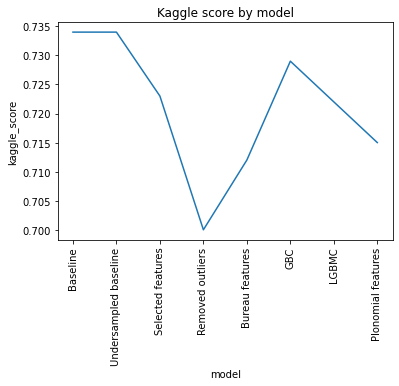

<IPython.core.display.Javascript object>

In [506]:
sns.lineplot(x=results["model"], y=results["kaggle_score"])
plt.xticks(rotation=90)
plt.title("Kaggle score by model")
plt.show()

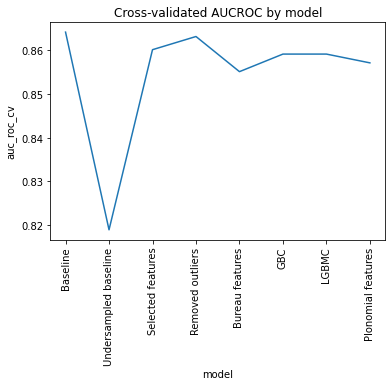

<IPython.core.display.Javascript object>

In [507]:
sns.lineplot(x=results["model"], y=results["auc_roc_cv"])
plt.xticks(rotation=90)
plt.title("Cross-validated AUCROC by model")
plt.show()

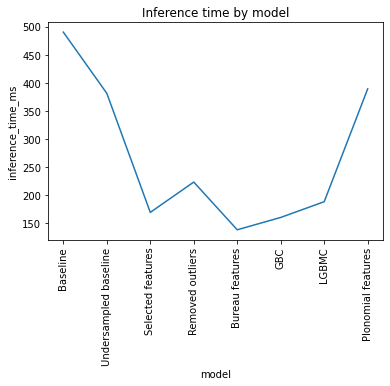

<IPython.core.display.Javascript object>

In [508]:
sns.lineplot(x=results["model"], y=results["inference_time_ms"])
plt.xticks(rotation=90)
plt.title("Inference time by model*")
plt.show()

*<i>Since the time is measured in milliseconds, it is very prone to other processes happening at the same time and using the CPU. Thus, this graph is only for visual purposes</i>

In conclusion, the simplest model was using only 27 selected features with a default Logistic Regression model. Although it did not achieve the required median Kaggle score, I am still happy with the result, since it was the fastest model and had the best precision and f1 scores.

Seeing the notebooks of other people, the models that managed to get better scores were either using complicated model blends/stacking with at least five different models or had hand-picked and manually engineered over 500 features.